In [66]:
import os
import glob
import natsort
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Some signal averaging for Mitchell

## Load files first
The data files are all placed in `data` folder

In [2]:
def get_files(pattern):
    """
    Extracts file in alphanumerical order that match the provided pattern
    """
    if isinstance(pattern, list):
        pattern = os.path.join(*pattern)
        
    files = natsort.natsorted(glob.glob(pattern))
    if not files:
        raise FileNotFoundError('Pattern could not detect file(s)')
        
    return files

In [22]:
import re

data_files = get_files('data/*.csv')
print('There are {} data csv files'.format(len(data_files)))

# split into cyan, yellow, magenta
cyan_data = [val for val in data_files if re.search(r'cyan\.csv', val)]
yellow_data = [val for val in data_files if re.search(r'yellow\.csv', val)]
magenta_data = [val for val in data_files if re.search(r'magenta\.csv', val)]

# sanity check to make sure they are the same number of files
assert len(cyan_data)==len(yellow_data)==len(magenta_data)

There are 168 data csv files


## Create channel specific dataframes

In [33]:
df_cyan = pd.concat((pd.read_csv(f, usecols=['Value']) for f in cyan_data), axis = 1).fillna(0)
df_yellow = pd.concat((pd.read_csv(f, usecols=['Value']) for f in yellow_data), axis = 1).fillna(0)
df_magenta = pd.concat((pd.read_csv(f, usecols=['Value']) for f in magenta_data), axis = 1).fillna(0)

# show example:
df_magenta.head()

,Value,Value,Value,Value,Value,Value,Value,Value,Value,Value,...,Value,Value,Value,Value,Value,Value,Value,Value,Value,Value
0,289.863,792.889,302.869,371.121,140.696,334.924,299.704,353.357,631.267,466.130,...,96.078,276.816,266.222,219.779,754.120,488.254,669.577,73.255,446.116,384.237
1,291.704,587.853,215.438,350.101,130.079,184.644,159.297,384.376,626.304,339.646,...,103.717,344.160,259.550,140.388,689.636,573.782,578.182,158.501,508.400,394.645
2,394.281,390.960,146.048,532.695,140.317,186.202,201.759,314.848,573.621,459.111,...,144.980,343.142,235.141,248.528,600.701,496.957,562.589,161.242,428.764,364.166
3,411.526,424.690,195.087,560.279,148.483,172.712,205.261,335.292,389.180,421.931,...,76.867,217.119,228.931,318.952,513.784,358.028,628.985,64.746,377.364,376.755
4,352.564,461.656,204.790,497.579,159.929,235.265,268.972,387.189,399.120,437.170,...,98.427,196.381,260.193,439.384,478.446,289.196,564.748,67.193,396.536,302.703


Now we have 3 Nx56 dataframes that are actually usable ... not stupid `.csv` files

### Center around max

In [55]:
# find which signal had the smallest number of pixels drawn, use this as standard length
shortest_cyan = np.argmax((df_cyan == 0).astype(int).sum(axis=0).values)
shortest_yellow = np.argmax((df_yellow == 0).astype(int).sum(axis=0).values)
shortest_magenta = np.argmax((df_magenta == 0).astype(int).sum(axis=0).values)
print('Shortest length of cyan is at column {}'.format(shortest_cyan))
print('Shortest length of yellow is at column {}'.format(shortest_yellow))
print('Shortest length of magenta is at column {}'.format(shortest_magenta))

Shortest length of cyan is at column 19
Shortest length of yellow is at column 19
Shortest length of magenta is at column 19


In [56]:
print('File 19 is {}'.format(cyan_data[shortest_cyan]))

File 19 is data/_9_4_cyan.csv


Seems like `_9_4_cyan.csv` is the one with the shortest line! Now we need to find where this guy's maximum is:

Cyan maximum is at index 7


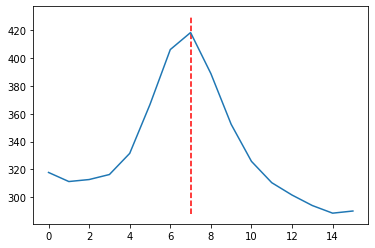

In [77]:
print('Cyan maximum is at index {}'.format(np.argmax(df_cyan.iloc[:,19].values)))
cyan_shortest_viz = df_cyan.iloc[:,19].values
plt.plot(np.ma.masked_equal(cyan_shortest_viz, 0))
plt.vlines(np.argmax(cyan_shortest_viz), ymin= 288, ymax = 430, linestyles = 'dashed', colors = 'r') 

Now we write a function to realign the data:

In [ ]:
def realign_data(in_data):
    """
    Center data around maximum of shortest column, pad with 0's 
    """
    